In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cvxopt

In [2]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5

In [3]:
class Kernel(object):
    
    @staticmethod
    def linear():
        return lambda x,y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        return lambda x,y: np.exp(-np.sqrt(np.linalg.norm(x-y) ** 2 / (2 * sigma ** 2)))

In [4]:
class SVMTrainer(object):
    
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c

    def train(self, X, y):
        
        lagrange_multipliers = self._compute_multipliers(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _kernel_matrix(self, X):
        
        n_samples, _ = X.shape
        K = np.zeros((n_samples, n_samples))
   
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)
                
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _compute_multipliers(self, X, y):
        
        n_samples, _ = X.shape

        K = self._kernel_matrix(X)

        P = cvxopt.matrix(np.outer(y, y) * K)
        
        q = cvxopt.matrix(-1 * np.ones(n_samples))

        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        
        h_std = cvxopt.matrix(np.zeros(n_samples))

        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))

        A = cvxopt.matrix(y, (1, n_samples))
        
        b = cvxopt.matrix(0.0)

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])

In [5]:
class SVMPredictor(object):
    
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

    def predict(self, x):
       
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()

In [12]:
%matplotlib inline
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools


def example(num_samples=10, num_features=2, grid_size=100):
    samples = np.matrix(np.random.normal(size=num_samples * num_features)
                        .reshape(num_samples, num_features))
    labels = 2 * (samples.sum(axis=1) > 0) - 1.0
    trainer = SVMTrainer(Kernel.gaussian(0.1))
    predictor = trainer.train(samples, labels)

    plot(predictor, samples, labels, grid_size)



def plot(predictor, X, y, grid_size):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.8
    )
    
    
    plt.scatter(
        flatten(X[:, 0]),
        flatten(X[:, 1]),
        c=flatten(y),
        cmap=cm.Paired
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

     pcost       dcost       gap    pres   dres
 0: -2.9706e+00 -2.3113e+00  3e+01  6e+00  1e-16
 1: -9.9839e-01 -1.8046e+00  1e+00  8e-02  4e-16
 2: -9.2366e-01 -9.8264e-01  6e-02  7e-17  3e-16
 3: -9.4886e-01 -9.4949e-01  6e-04  5e-17  3e-16
 4: -9.4914e-01 -9.4915e-01  6e-06  7e-17  2e-16
 5: -9.4915e-01 -9.4915e-01  6e-08  4e-17  2e-16
Optimal solution found.


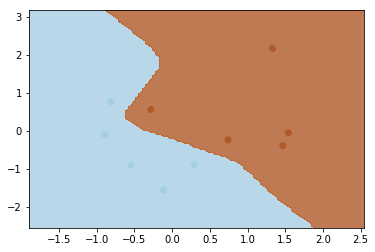

In [13]:
example()